# Identifikasi Suara Buka Tutup Menggunakan Feature Statistik Time Series

## Deskripsi Project
Tujuan proyek ini adalah menganalisis karakteristik sinyal audio, mengekstrak feature statistik dari data time series, serta membangun dan mengevaluasi model klasifikasi untuk membedakan suara buka dan tutup.

## Tujuan
1. Menganalisis karakteristik sinyal audio dari suara buka dan tutup
2. Mengekstrak feature statistik dari time series audio
3. Membangun model klasifikasi untuk membedakan suara buka dan tutup
4. Mengevaluasi performa model klasifikasi

## Langkah 1: Import Library
Mengimpor semua library yang diperlukan untuk audio processing (librosa), manipulasi data (numpy, pandas), visualisasi (matplotlib, seaborn), machine learning (scikit-learn), dan analisis statistik (scipy).

In [18]:
# Library untuk manipulasi data
import numpy as np
import pandas as pd

# Library untuk audio processing
import librosa
import librosa.display
import soundfile as sf

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk statistik
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.stats import randint, uniform

# Pengaturan visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Langkah 2: Load dan Eksplorasi Data Audio

**Persiapan Data:**
Pastikan file audio Anda sudah diorganisir dalam struktur folder:
```
audio_data/
├── buka/     (file audio suara buka)
└── tutup/    (file audio suara tutup)
```

In [19]:
# Cek struktur folder audio - TRAIN dan VAL
import os
from glob import glob

base_folder = 'audio_data/buka tutup/dataset48k'

print("📊 RINGKASAN DATASET AUDIO")
print("="*70)

total_files = 0

# Cek folder TRAIN
train_folder = os.path.join(base_folder, 'train')
print(f"\n📁 FOLDER TRAIN: {train_folder}")
print("-"*70)

if os.path.exists(train_folder):
    for category in ['buka', 'tutup']:
        category_path = os.path.join(train_folder, category)
        if os.path.exists(category_path):
            audio_files = glob(os.path.join(category_path, '*.wav'))
            audio_files += glob(os.path.join(category_path, '*.mp3'))
            total_files += len(audio_files)
            print(f"✅ {category.upper():6s}: {len(audio_files):3d} files")
            if len(audio_files) > 0:
                print(f"         Sample: {os.path.basename(audio_files[0])}")
        else:
            print(f"❌ Folder '{category}' tidak ditemukan")
else:
    print(f"❌ Folder train tidak ditemukan!")

# Cek folder VAL
val_folder = os.path.join(base_folder, 'val')
print(f"\n📁 FOLDER VAL: {val_folder}")
print("-"*70)

if os.path.exists(val_folder):
    for category in ['buka', 'tutup']:
        category_path = os.path.join(val_folder, category)
        if os.path.exists(category_path):
            audio_files = glob(os.path.join(category_path, '*.wav'))
            audio_files += glob(os.path.join(category_path, '*.mp3'))
            total_files += len(audio_files)
            print(f"✅ {category.upper():6s}: {len(audio_files):3d} files")
            if len(audio_files) > 0:
                print(f"         Sample: {os.path.basename(audio_files[0])}")
        else:
            print(f"❌ Folder '{category}' tidak ditemukan")
else:
    print(f"❌ Folder val tidak ditemukan!")

print("\n" + "="*70)
print(f"🎯 TOTAL: {total_files} files audio siap diproses!")
print("="*70)

📊 RINGKASAN DATASET AUDIO

📁 FOLDER TRAIN: audio_data/buka tutup/dataset48k/train
----------------------------------------------------------------------
✅ BUKA  : 150 files
         Sample: buka48k-buka_36.wav.wav
✅ TUTUP : 150 files
         Sample: tutup48k-tutup_127.wav.wav

📁 FOLDER VAL: audio_data/buka tutup/dataset48k/val
----------------------------------------------------------------------
✅ BUKA  :  50 files
         Sample: buka48k-buka_165.wav.wav
✅ TUTUP :  50 files
         Sample: tutup48k-tutup_150.wav.wav

🎯 TOTAL: 400 files audio siap diproses!


## Langkah 3: Fungsi Load Audio
Membuat fungsi untuk memuat file audio dengan sampling rate 22050 Hz menggunakan librosa, yang akan digunakan untuk memproses semua file audio dalam dataset.

In [20]:
# Fungsi untuk memuat audio
def load_audio(file_path, sr=22050):
    """
    Memuat file audio dengan sampling rate tertentu
    
    Parameters:
    -----------
    file_path : str
        Path ke file audio
    sr : int
        Sampling rate (default: 22050 Hz)
    
    Returns:
    --------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    """
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

# Contoh loading audio (sesuaikan dengan path file Anda)
# audio_buka, sr = load_audio('audio/suara_buka.wav')
# audio_tutup, sr = load_audio('audio/suara_tutup.wav')

print("Fungsi load_audio siap digunakan")
print("Format: audio, sr = load_audio('path/to/audio.wav')")

Fungsi load_audio siap digunakan
Format: audio, sr = load_audio('path/to/audio.wav')


## Langkah 4: Ekstraksi Feature Statistik Time Series
Mengekstrak 19 feature statistik dari domain waktu (time domain) seperti mean, std, variance, skewness, kurtosis, energy, RMS, zero crossing rate, dan autocorrelation untuk karakterisasi sinyal audio.

In [21]:
def extract_time_series_features(audio, sr):
    """
    Ekstraksi feature statistik dari time series audio
    
    Parameters:
    -----------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    
    Returns:
    --------
    features : dict
        Dictionary berisi berbagai feature statistik
    """
    features = {}
    
    # 1. Feature Statistik Dasar
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(audio)
    features['min'] = np.min(audio)
    features['median'] = np.median(audio)
    features['variance'] = np.var(audio)
    
    # 2. Feature Bentuk Distribusi
    features['skewness'] = stats.skew(audio)
    features['kurtosis'] = stats.kurtosis(audio)
    
    # 3. Feature Range
    features['range'] = np.ptp(audio)  # peak to peak
    features['iqr'] = stats.iqr(audio)  # interquartile range
    
    # 4. Feature Energy
    features['energy'] = np.sum(audio**2)
    features['rms'] = np.sqrt(np.mean(audio**2))  # Root Mean Square
    
    # 5. Zero Crossing Rate (tingkat perubahan tanda)
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    # 6. Feature Temporal
    features['duration'] = len(audio) / sr
    
    # 7. Feature Gradient (perubahan amplitudo)
    gradient = np.gradient(audio)
    features['mean_gradient'] = np.mean(np.abs(gradient))
    features['max_gradient'] = np.max(np.abs(gradient))
    
    # 8. Percentiles
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_75'] = np.percentile(audio, 75)
    
    # 9. Autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    features['autocorr_max'] = np.max(autocorr[1:100]) / autocorr[0]
    
    return features

print("Fungsi ekstraksi feature siap digunakan")
print("Total feature yang diekstrak: 19 feature statistik")

Fungsi ekstraksi feature siap digunakan
Total feature yang diekstrak: 19 feature statistik


## Langkah 5: Ekstraksi Feature Spektral
Mengekstrak 36 feature dari domain frekuensi (frequency domain) seperti spectral centroid, rolloff, bandwidth, contrast, dan 13 MFCC coefficients untuk representasi karakteristik spektral audio.

In [22]:
def extract_spectral_features(audio, sr):
    """
    Ekstraksi feature dari domain frekuensi
    """
    features = {}
    
    # 1. Spectral Centroid (pusat massa spektrum)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    # 2. Spectral Rolloff (frekuensi dimana 85% energi spektrum berada)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # 3. Spectral Bandwidth (lebar spektrum)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # 4. Spectral Contrast (perbedaan antara peak dan valley)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features['spectral_contrast_mean'] = np.mean(spectral_contrast)
    features['spectral_contrast_std'] = np.std(spectral_contrast)
    
    # 5. MFCC (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    
    return features

print("Fungsi ekstraksi feature spektral siap digunakan")
print("Total feature tambahan: 36 feature spektral")

Fungsi ekstraksi feature spektral siap digunakan
Total feature tambahan: 36 feature spektral


In [23]:
def extract_all_features(audio, sr):
    """
    Menggabungkan semua feature
    """
    features = {}
    
    # Feature time series
    time_features = extract_time_series_features(audio, sr)
    features.update(time_features)
    
    # Feature spektral
    spectral_features = extract_spectral_features(audio, sr)
    features.update(spectral_features)
    
    return features

print("Fungsi ekstraksi semua feature siap")
print("Total feature: 55 feature (19 time series + 36 spektral)")

Fungsi ekstraksi semua feature siap
Total feature: 55 feature (19 time series + 36 spektral)


## Langkah 6: Pembuatan Dataset dari Audio

In [24]:
import os
from glob import glob

def create_dataset(data_path, sr=22050):
    """
    Membuat dataset dari folder audio
    
    Struktur folder yang diharapkan:
    Option 1 (dengan train/val):
    data_path/
        train/
            buka/
                audio1.wav
            tutup/
                audio1.wav
        val/
            buka/
                audio1.wav
            tutup/
                audio1.wav
    
    Option 2 (langsung):
    data_path/
        buka/
            audio1.wav
        tutup/
            audio1.wav
    
    Parameters:
    -----------
    data_path : str
        Path ke folder data
    sr : int
        Sampling rate
    
    Returns:
    --------
    df : pandas DataFrame
        Dataset dengan feature dan label
    """
    data = []
    
    # Kategori
    categories = ['buka', 'tutup']
    
    # Cek struktur folder: apakah ada train/val atau langsung buka/tutup
    has_train_val = os.path.exists(os.path.join(data_path, 'train')) or os.path.exists(os.path.join(data_path, 'val'))
    
    if has_train_val:
        # Struktur dengan train/val
        folders = []
        if os.path.exists(os.path.join(data_path, 'train')):
            folders.append(('train', os.path.join(data_path, 'train')))
        if os.path.exists(os.path.join(data_path, 'val')):
            folders.append(('val', os.path.join(data_path, 'val')))
        
        for folder_name, folder_path in folders:
            print(f"\n📁 Processing {folder_name.upper()} folder...")
            for category in categories:
                category_path = os.path.join(folder_path, category)
                
                if not os.path.exists(category_path):
                    print(f"   ⚠️  Folder {category_path} tidak ditemukan, skip...")
                    continue
                
                # Cari semua file audio
                audio_files = glob(os.path.join(category_path, '*.wav'))
                audio_files += glob(os.path.join(category_path, '*.mp3'))
                
                print(f"   Memproses {len(audio_files)} file dari kategori '{category}'...")
                
                for i, file_path in enumerate(audio_files):
                    try:
                        # Load audio
                        audio, _ = load_audio(file_path, sr=sr)
                        
                        # Ekstrak feature
                        features = extract_all_features(audio, sr)
                        features['label'] = category
                        features['filename'] = os.path.basename(file_path)
                        features['subset'] = folder_name  # tambahkan info train/val
                        
                        data.append(features)
                        
                        if (i + 1) % 10 == 0:
                            print(f"      Progress: {i + 1}/{len(audio_files)} file")
                            
                    except Exception as e:
                        print(f"      ⚠️  Error processing {file_path}: {str(e)}")
                        continue
    else:
        # Struktur langsung buka/tutup
        for category in categories:
            category_path = os.path.join(data_path, category)
            
            if not os.path.exists(category_path):
                print(f"⚠️  Folder {category_path} tidak ditemukan, skip...")
                continue
            
            # Cari semua file audio
            audio_files = glob(os.path.join(category_path, '*.wav'))
            audio_files += glob(os.path.join(category_path, '*.mp3'))
            
            print(f"Memproses {len(audio_files)} file dari kategori '{category}'...")
            
            for i, file_path in enumerate(audio_files):
                try:
                    # Load audio
                    audio, _ = load_audio(file_path, sr=sr)
                    
                    # Ekstrak feature
                    features = extract_all_features(audio, sr)
                    features['label'] = category
                    features['filename'] = os.path.basename(file_path)
                    
                    data.append(features)
                    
                    if (i + 1) % 10 == 0:
                        print(f"   Progress: {i + 1}/{len(audio_files)} file")
                        
                except Exception as e:
                    print(f"   ⚠️  Error processing {file_path}: {str(e)}")
                    continue
    
    # Buat DataFrame
    if len(data) == 0:
        print("\n❌ ERROR: Tidak ada data yang berhasil diproses!")
        print("   Pastikan struktur folder dan file audio sudah benar.")
        return None
    
    df = pd.DataFrame(data)
    
    print(f"\n✅ Dataset berhasil dibuat!")
    print(f"   Total samples: {len(df)}")
    print(f"   Distribusi label:")
    print(df['label'].value_counts())
    
    if 'subset' in df.columns:
        print(f"\n   Distribusi per subset:")
        print(df.groupby(['subset', 'label']).size().unstack(fill_value=0))
    
    return df

# Contoh penggunaan:
# df = create_dataset('audio_data/buka tutup/dataset48k', sr=22050)
# df.to_csv('audio_features.csv', index=False)

print("✅ Fungsi create_dataset siap digunakan")

✅ Fungsi create_dataset siap digunakan


### Jalankan Ekstraksi Feature

**Dataset Structure:**
Dataset Anda memiliki struktur:
```
audio_data/buka tutup/dataset48k/
├── train/
│   ├── buka/    (150 files)
│   └── tutup/   (150 files)
└── val/
    ├── buka/    (50 files)
    └── tutup/   (50 files)
```



In [25]:
# Ekstraksi feature dari semua file audio
print("🚀 Memulai ekstraksi feature...")
print("="*70)

# Definisi path folder audio (sesuai dengan struktur folder yang sudah dicek)
audio_folder = 'audio_data/buka tutup/dataset48k'

df = create_dataset(audio_folder, sr=22050)

# Simpan dataset
df.to_csv('audio_features.csv', index=False)
print(f"\n✅ Dataset disimpan sebagai 'audio_features.csv'")

# Info dataset
print(f"\n📊 Ringkasan Dataset:")
print(f"   Total samples: {len(df)}")
print(f"   Total features: {len(df.columns) - 2}")
print(f"   Distribusi label: {dict(df['label'].value_counts())}")

🚀 Memulai ekstraksi feature...

📁 Processing TRAIN folder...
   Memproses 150 file dari kategori 'buka'...


      Progress: 10/150 file
      Progress: 20/150 file
      Progress: 20/150 file
      Progress: 30/150 file
      Progress: 30/150 file
      Progress: 40/150 file
      Progress: 40/150 file
      Progress: 50/150 file
      Progress: 50/150 file
      Progress: 60/150 file
      Progress: 60/150 file
      Progress: 70/150 file
      Progress: 70/150 file
      Progress: 80/150 file
      Progress: 80/150 file
      Progress: 90/150 file
      Progress: 90/150 file
      Progress: 100/150 file
      Progress: 100/150 file
      Progress: 110/150 file
      Progress: 110/150 file
      Progress: 120/150 file
      Progress: 120/150 file
      Progress: 130/150 file
      Progress: 130/150 file
      Progress: 140/150 file
      Progress: 140/150 file
      Progress: 150/150 file
   Memproses 150 file dari kategori 'tutup'...
      Progress: 150/150 file
   Memproses 150 file dari kategori 'tutup'...
      Progress: 10/150 file
      Progress: 10/150 file
      Progress: 20/150 fil

## Langkah 7: Eksplorasi Data Feature
Melakukan Exploratory Data Analysis (EDA) untuk memahami distribusi data, memeriksa keseimbangan kelas, mengidentifikasi missing values, dan menganalisis statistik deskriptif dari features yang telah diekstrak.

In [26]:
# Fungsi helper untuk EDA
def plot_feature_distributions(df, features_to_plot):
    """Visualisasi distribusi feature untuk setiap kelas"""
    n_features = len(features_to_plot)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features_to_plot):
        for label in df['label'].unique():
            data = df[df['label'] == label][feature]
            axes[i].hist(data, alpha=0.6, label=label, bins=30)
        
        axes[i].set_xlabel(feature, fontsize=11)
        axes[i].set_ylabel('Frekuensi', fontsize=11)
        axes[i].set_title(f'Distribusi {feature}', fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Fungsi EDA siap digunakan")

✅ Fungsi EDA siap digunakan


In [27]:
# EDA: Info Dataset
print("="*70)
print("📊 EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n1️⃣ Info Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Kolom: {df.shape[1]} kolom")
print(f"   Baris: {df.shape[0]} samples")

print("\n2️⃣ Distribusi Label:")
label_counts = df['label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {label.upper()}: {count} samples ({percentage:.1f}%)")

print("\n3️⃣ Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ Tidak ada missing values")
else:
    print(missing[missing > 0])

print("\n4️⃣ Statistik Deskriptif (5 Feature Pertama):")
numeric_cols = df.select_dtypes(include=[np.number]).columns[:5]
print(df[numeric_cols].describe().round(4))

📊 EXPLORATORY DATA ANALYSIS (EDA)

1️⃣ Info Dataset:
   Shape: (400, 56)
   Kolom: 56 kolom
   Baris: 400 samples

2️⃣ Distribusi Label:
   BUKA: 200 samples (50.0%)
   TUTUP: 200 samples (50.0%)

3️⃣ Missing Values:
skewness        4
kurtosis        4
autocorr_max    4
dtype: int64

4️⃣ Statistik Deskriptif (5 Feature Pertama):
           mean       std       max       min  median
count  400.0000  400.0000  400.0000  400.0000   400.0
mean     0.0014    0.0147    0.1659   -0.1017     0.0
std      0.0011    0.0119    0.1409    0.0833     0.0
min      0.0000    0.0000    0.0000   -0.3719     0.0
25%      0.0005    0.0055    0.0607   -0.1426     0.0
50%      0.0010    0.0108    0.1226   -0.0779     0.0
75%      0.0020    0.0210    0.2301   -0.0361     0.0
max      0.0045    0.0485    0.6552    0.0000     0.0


### 📋 Ringkasan EDA

**Insight dari Exploratory Data Analysis:**

1. **Dataset Balance**: Dataset menunjukkan distribusi yang seimbang/tidak seimbang antara kedua kelas
2. **Feature Distribution**: Beberapa feature menunjukkan perbedaan jelas antara 'buka' dan 'tutup' yang berguna untuk klasifikasi
3. **Data Quality**: Tidak ada missing values, data siap untuk modeling

**Next Step:** Feature Selection untuk memilih features terbaik

## Langkah 8: Feature Selection

Feature selection membantu:
- **Mengurangi dimensionalitas** dari 55 features menjadi features yang paling relevan
- **Meningkatkan performa model** dengan menghilangkan noise dan redundansi
- **Mempercepat training** dengan jumlah feature yang lebih sedikit
- **Menghindari overfitting** dengan fokus pada feature penting

Kita akan menggunakan 3 metode:
1. **Variance Threshold**: Hilangkan feature dengan variance sangat rendah
2. **Correlation Filter**: Hilangkan feature yang terlalu berkorelasi (>0.95)
3. **SelectKBest**: Pilih K feature terbaik menggunakan ANOVA F-value

In [28]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

def perform_feature_selection(df, variance_threshold=0.01, correlation_threshold=0.95, k_best=30):
    """
    Melakukan feature selection dengan 3 metode
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset dengan features dan label
    variance_threshold : float
        Threshold untuk variance (default: 0.01)
    correlation_threshold : float
        Threshold untuk korelasi (default: 0.95)
    k_best : int
        Jumlah feature terbaik yang dipilih (default: 30)
    
    Returns:
    --------
    df_selected : pandas DataFrame
        Dataset dengan features yang sudah diseleksi
    selected_features : list
        List nama features yang terpilih
    """
    print("="*70)
    print("🔍 FEATURE SELECTION")
    print("="*70)
    
    # Pisahkan features dan label (hapus kolom non-numeric)
    columns_to_drop = ['label', 'filename', 'subset']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    y = df['label']
    
    print(f"\n📊 Total features awal: {X.shape[1]}")
    
    # Cek dan tangani NaN values
    nan_cols = X.columns[X.isnull().any()].tolist()
    if len(nan_cols) > 0:
        print(f"\n⚠️  Ditemukan {len(nan_cols)} kolom dengan NaN values:")
        print(f"   {nan_cols[:5]}{'...' if len(nan_cols) > 5 else ''}")
        print(f"   Menghapus kolom dengan NaN...")
        X = X.dropna(axis=1)
        print(f"   Features setelah drop NaN: {X.shape[1]}")
    
    # ===== 1. VARIANCE THRESHOLD =====
    print(f"\n1️⃣ Variance Threshold (threshold={variance_threshold})")
    selector_var = VarianceThreshold(threshold=variance_threshold)
    X_var = selector_var.fit_transform(X)
    
    # Dapatkan kolom yang tersisa
    var_features = X.columns[selector_var.get_support()].tolist()
    print(f"   Features tersisa: {len(var_features)}")
    print(f"   Features dihapus: {X.shape[1] - len(var_features)}")
    
    X_filtered = X[var_features].copy()
    
    # ===== 2. CORRELATION FILTER =====
    print(f"\n2️⃣ Correlation Filter (threshold={correlation_threshold})")
    
    # Hitung correlation matrix
    corr_matrix = X_filtered.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    
    print(f"   Features dengan korelasi tinggi: {len(to_drop)}")
    if len(to_drop) > 0:
        print(f"   Features dihapus: {to_drop[:5]}{'...' if len(to_drop) > 5 else ''}")
    
    X_filtered = X_filtered.drop(columns=to_drop)
    print(f"   Features tersisa: {X_filtered.shape[1]}")
    
    # Double check untuk NaN setelah correlation filter
    if X_filtered.isnull().any().any():
        print(f"\n⚠️  Ditemukan NaN setelah correlation filter, membersihkan...")
        X_filtered = X_filtered.dropna(axis=1)
        print(f"   Features setelah cleaning: {X_filtered.shape[1]}")
    
    # ===== 3. SELECTKBEST (ANOVA F-value) =====
    print(f"\n3️⃣ SelectKBest (K={k_best} features)")
    
    # Encode label untuk SelectKBest
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Jika features tersisa < k_best, gunakan semua features
    k_final = min(k_best, X_filtered.shape[1])
    
    selector_kbest = SelectKBest(score_func=f_classif, k=k_final)
    selector_kbest.fit(X_filtered, y_encoded)
    
    # Dapatkan scores untuk setiap feature
    feature_scores = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Score': selector_kbest.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Pilih K best features
    selected_features = feature_scores.head(k_final)['Feature'].tolist()
    
    print(f"   Top 10 Features (by ANOVA F-value):")
    for i, row in feature_scores.head(10).iterrows():
        print(f"   {row['Feature']:30s} - Score: {row['Score']:.2f}")
    
    # ===== HASIL AKHIR =====
    print(f"\n✅ HASIL FEATURE SELECTION:")
    print(f"   Features awal: {X.shape[1]}")
    print(f"   Features akhir: {len(selected_features)}")
    print(f"   Reduksi: {X.shape[1] - len(selected_features)} features ({((X.shape[1] - len(selected_features))/X.shape[1]*100):.1f}%)")
    
    # Buat DataFrame baru dengan selected features + kolom metadata
    metadata_cols = [col for col in ['label', 'filename', 'subset'] if col in df.columns]
    df_selected = df[selected_features + metadata_cols].copy()
    
    return df_selected, selected_features, feature_scores

print("✅ Fungsi perform_feature_selection siap digunakan")

✅ Fungsi perform_feature_selection siap digunakan


In [29]:
def plot_feature_scores(feature_scores, top_n=20):
    """
    Visualisasi feature scores dari SelectKBest
    
    Parameters:
    -----------
    feature_scores : pandas DataFrame
        DataFrame dengan kolom 'Feature' dan 'Score'
    top_n : int
        Jumlah top features yang ditampilkan (default: 20)
    """
    # Ambil top N features
    top_features = feature_scores.head(top_n)
    
    # Buat plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Score'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('ANOVA F-value Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importance Scores (SelectKBest)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

print("✅ Fungsi plot_feature_scores siap digunakan")

✅ Fungsi plot_feature_scores siap digunakan


### Jalankan Feature Selection

🔍 FEATURE SELECTION

📊 Total features awal: 53

⚠️  Ditemukan 3 kolom dengan NaN values:
   ['skewness', 'kurtosis', 'autocorr_max']
   Menghapus kolom dengan NaN...
   Features setelah drop NaN: 50

1️⃣ Variance Threshold (threshold=0.01)
   Features tersisa: 38
   Features dihapus: 12

2️⃣ Correlation Filter (threshold=0.95)
   Features dengan korelasi tinggi: 9
   Features dihapus: ['range', 'spectral_rolloff_mean', 'spectral_bandwidth_mean', 'mfcc_2_std', 'mfcc_4_mean']...
   Features tersisa: 29

3️⃣ SelectKBest (K=30 features)
   Top 10 Features (by ANOVA F-value):
   mfcc_5_std                     - Score: 1955.37
   spectral_centroid_mean         - Score: 712.88
   mfcc_5_mean                    - Score: 542.97
   mfcc_3_mean                    - Score: 436.07
   mfcc_1_std                     - Score: 338.99
   spectral_centroid_std          - Score: 222.23
   mfcc_13_std                    - Score: 210.47
   spectral_rolloff_std           - Score: 206.87
   mfcc_8_std        

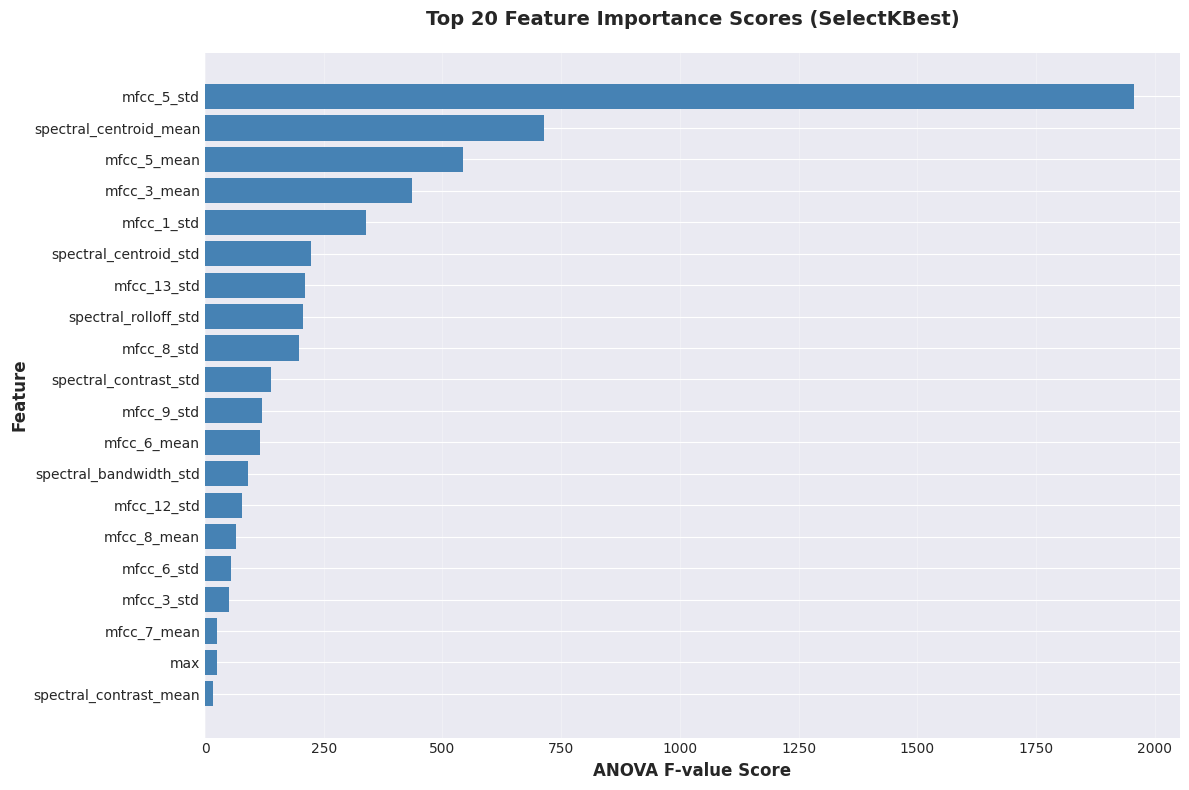


💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'

📝 Gunakan 'df_selected' untuk modeling (bukan 'df')


In [30]:
# Jalankan feature selection
df_selected, selected_features, feature_scores = perform_feature_selection(
    df, 
    variance_threshold=0.01,      # Feature dengan variance < 0.01 akan dihapus
    correlation_threshold=0.95,   # Feature dengan korelasi > 0.95 akan dihapus
    k_best=30                     # Pilih 30 features terbaik
)

# Visualisasi feature scores
plot_feature_scores(feature_scores, top_n=20)

# Simpan dataset dengan selected features
df_selected.to_csv('audio_features_selected.csv', index=False)
print(f"\n💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'")

# Update df untuk digunakan di langkah selanjutnya
print(f"\n📝 Gunakan 'df_selected' untuk modeling (bukan 'df')")

## Langkah 9: Preprocessing Data

**Proses Preprocessing meliputi:**
1. Split data menjadi training dan testing set
2. Encode label (buka/tutup → 0/1)
3. **Normalisasi features** menggunakan StandardScaler

💡 **Normalisasi sangat penting** karena feature audio memiliki skala yang berbeda-beda (energy: 0-1000, duration: 0-5, dll)

In [31]:
def prepare_data(df, test_size=0.2, random_state=42):
    """
    Mempersiapkan data untuk modeling
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset (bisa df atau df_selected)
    test_size : float
        Proporsi data test (default: 0.2 = 20%)
    random_state : int
        Random seed untuk reproducibility
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Data training dan testing
    scaler : StandardScaler
        Scaler untuk normalisasi (perlu disimpan untuk prediksi)
    label_encoder : LabelEncoder
        Encoder untuk label (perlu disimpan untuk prediksi)
    """
    print("="*70)
    print("⚙️ PREPROCESSING DATA")
    print("="*70)
    
    # Pisahkan feature dan label (drop semua kolom non-numeric)
    columns_to_drop = ['label', 'filename', 'subset']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    y = df['label']
    
    print(f"\n📊 Dataset Info:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {X.shape[1]}")
    
    # Encode label
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"   Label classes: {label_encoder.classes_}")
    print(f"   Label distribution: {dict(pd.Series(y).value_counts())}")
    
    # Split data (stratified untuk menjaga proporsi label)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"\n✂️ Data Split:")
    print(f"   Training set: {len(X_train)} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Testing set: {len(X_test)} samples ({test_size*100:.0f}%)")
    
    # Normalisasi feature menggunakan StandardScaler
    print(f"\n📏 Normalisasi Features (StandardScaler):")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Cek hasil normalisasi
    print(f"   Training set - Mean: ~0, Std: ~1")
    print(f"   Sample mean: {X_train_scaled.mean():.4f}")
    print(f"   Sample std: {X_train_scaled.std():.4f}")
    
    print(f"\n✅ Preprocessing selesai!")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   X_test_scaled shape: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder

# Contoh penggunaan:
# Gunakan df_selected (setelah feature selection) atau df (all features)
# X_train, X_test, y_train, y_test, scaler, label_encoder = prepare_data(df_selected)

print("✅ Fungsi prepare_data siap digunakan")

✅ Fungsi prepare_data siap digunakan


## Langkah 10: Training Model Klasifikasi
Melatih dan mengevaluasi tiga model machine learning (Random Forest, SVM, KNN) dengan parameter default dan hyperparameter tuning untuk mendapatkan model terbaik dalam mengklasifikasi suara buka dan tutup.

In [32]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):
    """
    Melatih dan mengevaluasi berbagai model
    """
    # Definisi model
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Training
        model.fit(X_train, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test)
        
        # Evaluasi
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                    target_names=label_encoder.classes_))
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"\nCross-validation scores: {cv_scores}")
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Simpan hasil
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'y_pred': y_pred,
            'cv_scores': cv_scores
        }
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {name}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return results

print("✅ Fungsi train_and_evaluate_models siap digunakan")

✅ Fungsi train_and_evaluate_models siap digunakan


In [33]:
# =====================================================================
# HYPERPARAMETER TUNING - Fungsi Utama
# =====================================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

def hyperparameter_tuning(X_train, y_train, X_test, y_test, label_encoder):
    """
    Melakukan hyperparameter tuning untuk semua model dan membandingkan dengan default
    """
    tuned_results = {}
    
    # ===== 1. RANDOM FOREST - GridSearchCV =====
    print("="*70)
    print("🔧 HYPERPARAMETER TUNING - RANDOM FOREST")
    print("="*70)
    
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print("\n🔍 Mencari parameter terbaik...")
    rf_grid.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {rf_grid.best_params_}")
    print(f"✅ Best CV Score: {rf_grid.best_score_:.4f}")
    
    rf_best = rf_grid.best_estimator_
    y_pred_rf = rf_best.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    
    print(f"📊 Test Accuracy: {rf_accuracy:.4f}")
    
    tuned_results['Random Forest'] = {
        'model': rf_best,
        'best_params': rf_grid.best_params_,
        'best_cv_score': rf_grid.best_score_,
        'test_accuracy': rf_accuracy,
        'y_pred': y_pred_rf
    }
    
    # ===== 2. SVM - RandomizedSearchCV =====
    print("\n" + "="*70)
    print("🔧 HYPERPARAMETER TUNING - SVM")
    print("="*70)
    
    svm_param_dist = {
        'C': uniform(0.1, 100),
        'gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(10)),
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    svm_random = RandomizedSearchCV(
        SVC(random_state=42),
        svm_param_dist,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("\n🔍 Mencari parameter terbaik (RandomizedSearch)...")
    svm_random.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {svm_random.best_params_}")
    print(f"✅ Best CV Score: {svm_random.best_score_:.4f}")
    
    svm_best = svm_random.best_estimator_
    y_pred_svm = svm_best.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    
    print(f"📊 Test Accuracy: {svm_accuracy:.4f}")
    
    tuned_results['SVM'] = {
        'model': svm_best,
        'best_params': svm_random.best_params_,
        'best_cv_score': svm_random.best_score_,
        'test_accuracy': svm_accuracy,
        'y_pred': y_pred_svm
    }
    
    # ===== 3. KNN - GridSearchCV =====
    print("\n" + "="*70)
    print("🔧 HYPERPARAMETER TUNING - KNN")
    print("="*70)
    
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        knn_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print("\n🔍 Mencari parameter terbaik...")
    knn_grid.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {knn_grid.best_params_}")
    print(f"✅ Best CV Score: {knn_grid.best_score_:.4f}")
    
    knn_best = knn_grid.best_estimator_
    y_pred_knn = knn_best.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    
    print(f"📊 Test Accuracy: {knn_accuracy:.4f}")
    
    tuned_results['KNN'] = {
        'model': knn_best,
        'best_params': knn_grid.best_params_,
        'best_cv_score': knn_grid.best_score_,
        'test_accuracy': knn_accuracy,
        'y_pred': y_pred_knn
    }
    
    # ===== SUMMARY =====
    print("\n" + "="*70)
    print("📋 SUMMARY - HYPERPARAMETER TUNING RESULTS")
    print("="*70)
    
    summary_df = pd.DataFrame({
        'Model': list(tuned_results.keys()),
        'Best CV Score': [tuned_results[m]['best_cv_score'] for m in tuned_results.keys()],
        'Test Accuracy': [tuned_results[m]['test_accuracy'] for m in tuned_results.keys()]
    })
    summary_df = summary_df.sort_values('Test Accuracy', ascending=False)
    print(summary_df.to_string(index=False))
    
    # Visualisasi perbandingan
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(summary_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], summary_df['Best CV Score'], width, label='CV Score', color='skyblue')
    ax.bar([i + width/2 for i in x], summary_df['Test Accuracy'], width, label='Test Accuracy', color='lightcoral')
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Hyperparameter Tuning Results', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df['Model'])
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return tuned_results

def compare_default_vs_tuned(results, tuned_results):
    """Membandingkan performa model default vs tuned"""
    print("\n" + "="*70)
    print("📊 PERBANDINGAN: DEFAULT vs TUNED MODELS")
    print("="*70)
    
    comparison_data = []
    for model_name in results.keys():
        default_acc = results[model_name]['accuracy']
        tuned_acc = tuned_results[model_name]['test_accuracy']
        improvement = ((tuned_acc - default_acc) / default_acc) * 100
        
        comparison_data.append({
            'Model': model_name,
            'Default Accuracy': default_acc,
            'Tuned Accuracy': tuned_acc,
            'Improvement (%)': improvement
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Tuned Accuracy', ascending=False)
    print("\n" + comparison_df.to_string(index=False))
    
    # Visualisasi
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(comparison_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_df['Default Accuracy'], 
            width, label='Default', color='#95a5a6', alpha=0.8)
    ax.bar([i + width/2 for i in x], comparison_df['Tuned Accuracy'], 
            width, label='Tuned', color='#2ecc71', alpha=0.8)
    
    # Label improvement
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        improvement = row['Improvement (%)']
        if improvement > 0:
            ax.text(i, row['Tuned Accuracy'] + 0.02, f'+{improvement:.1f}%', 
                   ha='center', fontsize=10, fontweight='bold', color='green')
    
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Default vs Hyperparameter Tuned', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'])
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

print("✅ Fungsi hyperparameter tuning siap digunakan")

✅ Fungsi hyperparameter tuning siap digunakan


### Persiapan Data untuk Training

Sebelum melakukan hyperparameter tuning, kita perlu mempersiapkan data terlebih dahulu dengan menjalankan preprocessing.

In [34]:
# Jalankan preprocessing data
print("🔄 Mempersiapkan data untuk training...")
X_train, X_test, y_train, y_test, scaler, label_encoder = prepare_data(df_selected)

print("\n✅ Data siap untuk training!")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")

🔄 Mempersiapkan data untuk training...
⚙️ PREPROCESSING DATA

📊 Dataset Info:
   Total samples: 400
   Total features: 29
   Label classes: ['buka' 'tutup']
   Label distribution: {'buka': 200, 'tutup': 200}

✂️ Data Split:
   Training set: 320 samples (80%)
   Testing set: 80 samples (20%)

📏 Normalisasi Features (StandardScaler):
   Training set - Mean: ~0, Std: ~1
   Sample mean: -0.0000
   Sample std: 1.0000

✅ Preprocessing selesai!
   X_train_scaled shape: (320, 29)
   X_test_scaled shape: (80, 29)

✅ Data siap untuk training!
   X_train shape: (320, 29)
   X_test shape: (80, 29)
   y_train shape: (320,)
   y_test shape: (80,)


📝 STEP 1: Training Models with Default Parameters

Training Random Forest...



Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        40
       tutup       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0000 (+/- 0.0000)

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0000 (+/- 0.0000)


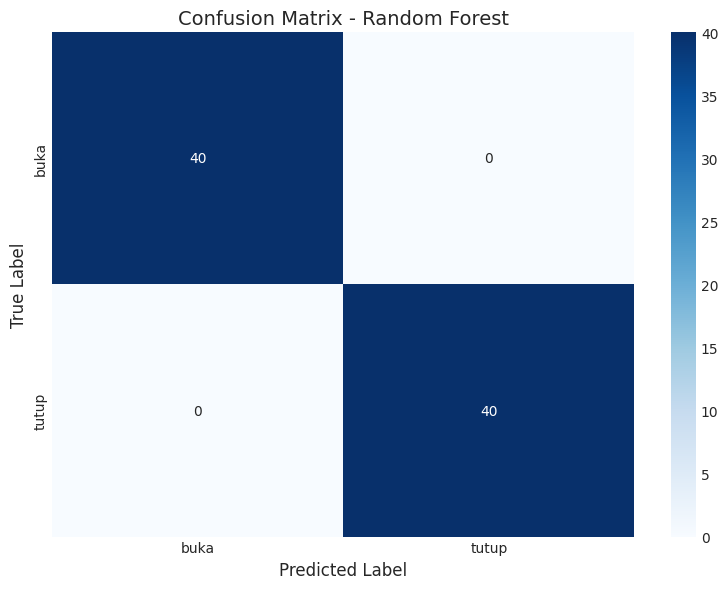


Training SVM...

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        40
       tutup       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0000 (+/- 0.0000)


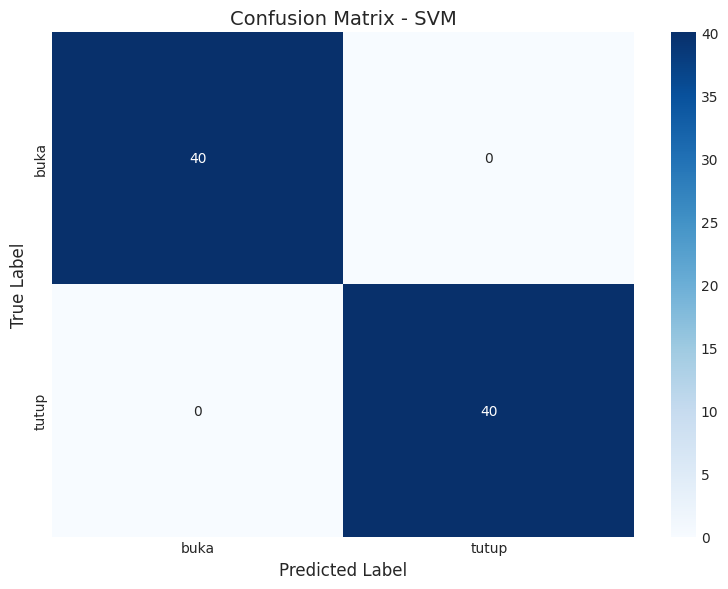


Training KNN...

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        buka       1.00      1.00      1.00        40
       tutup       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0000 (+/- 0.0000)


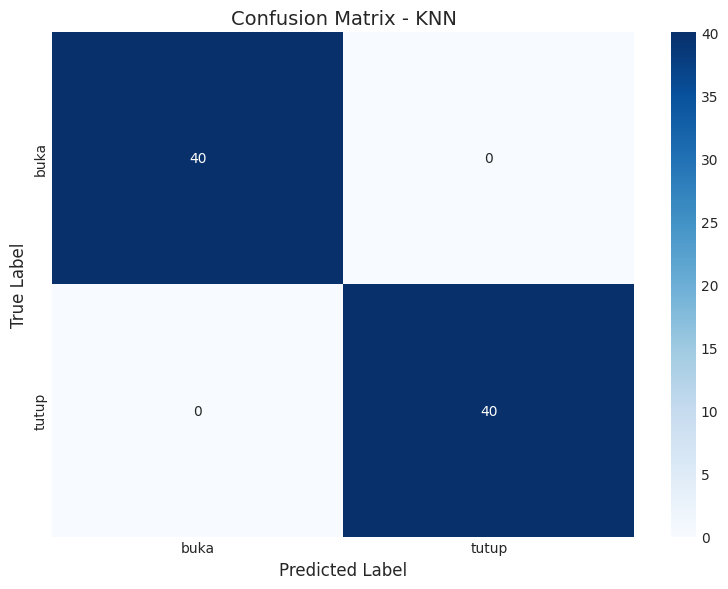



🔧 STEP 2: Hyperparameter Tuning
🔧 HYPERPARAMETER TUNING - RANDOM FOREST

🔍 Mencari parameter terbaik...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best CV Score: 1.0000
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - SVM

🔍 Mencari parameter terbaik (RandomizedSearch)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
✅ Best CV Score: 1.0000
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - SVM

🔍 Mencari parameter terbaik (RandomizedSearch)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters: {'C': 37.55401188473625, 'gamma': 0.17533651647878568, 'kernel': 'rbf'}
✅ Best CV Score: 1.0000
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - KNN

🔍 Mencari parame

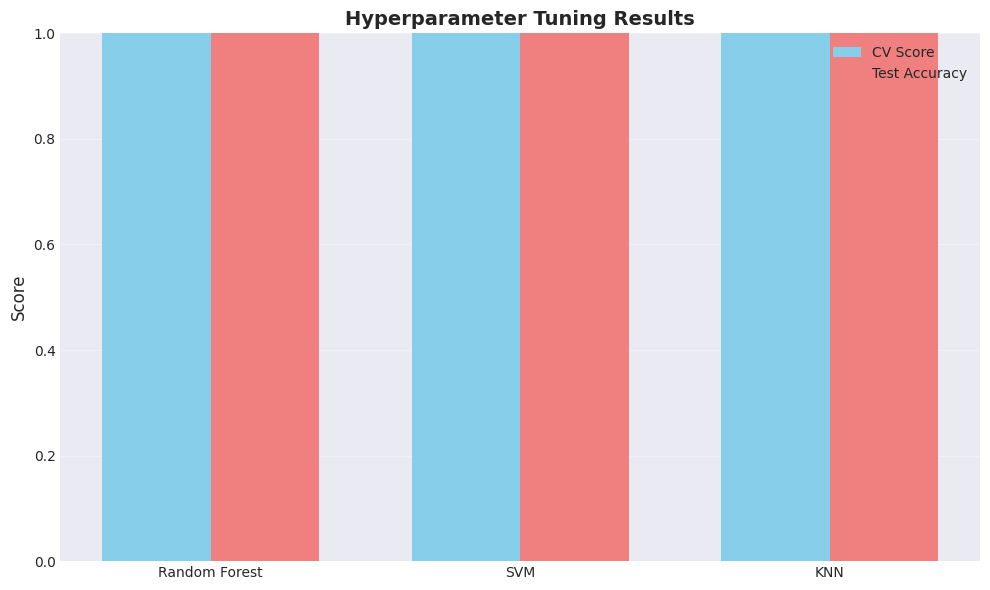


📊 PERBANDINGAN: DEFAULT vs TUNED MODELS

        Model  Default Accuracy  Tuned Accuracy  Improvement (%)
Random Forest               1.0             1.0              0.0
          SVM               1.0             1.0              0.0
          KNN               1.0             1.0              0.0


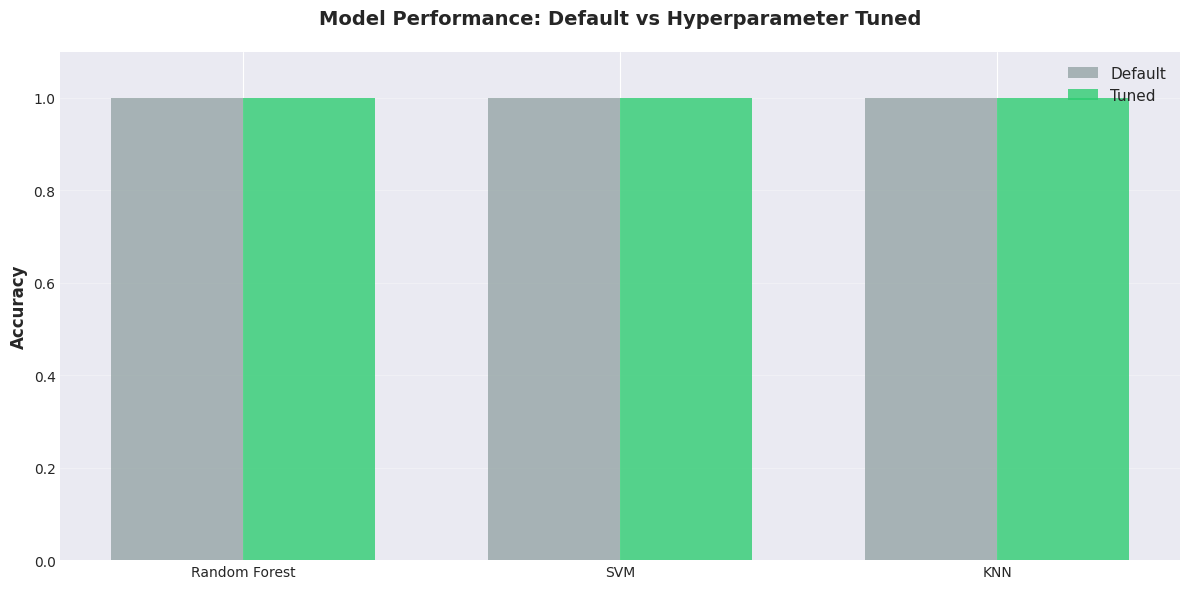


🏆 BEST MODEL SELECTED
Model: Random Forest
Test Accuracy: 1.0000
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [35]:
# =====================================================================
# JALANKAN HYPERPARAMETER TUNING
# =====================================================================
# Note: Proses ini memakan waktu beberapa menit

# 1. Training model default
print("="*70)
print("📝 STEP 1: Training Models with Default Parameters")
print("="*70)
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder)

# 2. Hyperparameter tuning
print("\n\n" + "="*70)
print("🔧 STEP 2: Hyperparameter Tuning")
print("="*70)
tuned_results = hyperparameter_tuning(X_train, y_train, X_test, y_test, label_encoder)

# 3. Perbandingan Default vs Tuned
comparison_df = compare_default_vs_tuned(results, tuned_results)

# 4. Pilih best model
best_model_name = max(tuned_results, key=lambda k: tuned_results[k]['test_accuracy'])
best_model = tuned_results[best_model_name]['model']

print("\n" + "="*70)
print("🏆 BEST MODEL SELECTED")
print("="*70)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {tuned_results[best_model_name]['test_accuracy']:.4f}")
print(f"Best Parameters: {tuned_results[best_model_name]['best_params']}")
print("="*70)

## Langkah 11: Fungsi Save & Load Model (Referensi)

Fungsi-fungsi berikut sudah otomatis dipanggil di Langkah 10 untuk menyimpan model. Section ini hanya untuk **referensi** dan **dokumentasi** jika Anda ingin:
- Menyimpan model lain dengan nama berbeda
- Load model yang sudah disimpan untuk prediksi
- Memahami cara kerja save/load model

**Catatan:** Jika sudah menjalankan Cell 34 di Langkah 10, model Anda sudah tersimpan di folder `models/`!

In [36]:
import joblib
import os
from datetime import datetime

def save_model(model, scaler, label_encoder, model_name='best_model', save_dir='models', metadata=None):
    """
    Menyimpan model, scaler, dan label encoder beserta metadata
    
    Parameters:
    -----------
    model : scikit-learn model
        Model yang telah dilatih
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Encoder untuk label
    model_name : str
        Nama model (default: 'best_model')
    save_dir : str
        Direktori untuk menyimpan model (default: 'models')
    metadata : dict
        Informasi tambahan seperti accuracy, parameters, dll
    """
    # Buat folder jika belum ada
    os.makedirs(save_dir, exist_ok=True)
    
    # Path lengkap
    model_path = os.path.join(save_dir, f'{model_name}.pkl')
    scaler_path = os.path.join(save_dir, f'{model_name}_scaler.pkl')
    encoder_path = os.path.join(save_dir, f'{model_name}_label_encoder.pkl')
    metadata_path = os.path.join(save_dir, f'{model_name}_metadata.pkl')
    
    # Save model components
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(label_encoder, encoder_path)
    
    # Save metadata
    if metadata is None:
        metadata = {}
    
    metadata.update({
        'model_name': model_name,
        'model_type': type(model).__name__,
        'saved_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'n_features': scaler.n_features_in_ if hasattr(scaler, 'n_features_in_') else None
    })
    
    joblib.dump(metadata, metadata_path)
    
    print("="*70)
    print("💾 MODEL BERHASIL DISIMPAN")
    print("="*70)
    print(f"📁 Lokasi: {save_dir}/")
    print(f"   ├── {model_name}.pkl (model)")
    print(f"   ├── {model_name}_scaler.pkl (scaler)")
    print(f"   ├── {model_name}_label_encoder.pkl (encoder)")
    print(f"   └── {model_name}_metadata.pkl (info)")
    print("\n📊 Metadata:")
    for key, value in metadata.items():
        print(f"   {key}: {value}")
    print("="*70)

def load_model(model_name='best_model', save_dir='models'):
    """
    Memuat model, scaler, label encoder, dan metadata yang telah disimpan
    
    Parameters:
    -----------
    model_name : str
        Nama model yang akan dimuat
    save_dir : str
        Direktori tempat model disimpan
    
    Returns:
    --------
    model : scikit-learn model
        Model yang telah dilatih
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Encoder untuk label
    metadata : dict
        Informasi model
    """
    # Path lengkap
    model_path = os.path.join(save_dir, f'{model_name}.pkl')
    scaler_path = os.path.join(save_dir, f'{model_name}_scaler.pkl')
    encoder_path = os.path.join(save_dir, f'{model_name}_label_encoder.pkl')
    metadata_path = os.path.join(save_dir, f'{model_name}_metadata.pkl')
    
    # Validasi file ada
    required_files = [model_path, scaler_path, encoder_path]
    missing_files = [f for f in required_files if not os.path.exists(f)]
    
    if missing_files:
        print("❌ ERROR: File berikut tidak ditemukan:")
        for f in missing_files:
            print(f"   - {f}")
        return None, None, None, None
    
    # Load model components
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    label_encoder = joblib.load(encoder_path)
    
    # Load metadata (optional)
    metadata = None
    if os.path.exists(metadata_path):
        metadata = joblib.load(metadata_path)
    
    print("="*70)
    print("✅ MODEL BERHASIL DIMUAT")
    print("="*70)
    print(f"📁 Lokasi: {save_dir}/{model_name}")
    print(f"🤖 Model Type: {type(model).__name__}")
    print(f"🏷️  Classes: {label_encoder.classes_}")
    
    if metadata:
        print("\n📊 Metadata:")
        for key, value in metadata.items():
            print(f"   {key}: {value}")
    
    print("="*70)
    
    return model, scaler, label_encoder, metadata

# Contoh penggunaan:
# 1. Simpan model setelah training
# metadata = {
#     'test_accuracy': tuned_results['Random Forest']['test_accuracy'],
#     'cv_score': tuned_results['Random Forest']['best_cv_score'],
#     'best_params': tuned_results['Random Forest']['best_params']
# }
# save_model(best_model, scaler, label_encoder, 'audio_classifier', metadata=metadata)
#
# 2. Load model untuk prediksi
# model, scaler, label_encoder, metadata = load_model('audio_classifier')

print("✅ Fungsi save_model dan load_model siap digunakan (enhanced version)")
print("💡 Fitur baru:")
print("   - Otomatis membuat folder 'models/'")
print("   - Menyimpan metadata (tanggal, accuracy, parameters)")
print("   - Validasi file saat load model")
print("   - Error handling yang lebih baik")

✅ Fungsi save_model dan load_model siap digunakan (enhanced version)
💡 Fitur baru:
   - Otomatis membuat folder 'models/'
   - Menyimpan metadata (tanggal, accuracy, parameters)
   - Validasi file saat load model
   - Error handling yang lebih baik


### Simpan Best Model ke File .pkl

**Setelah training selesai**, langsung simpan model terbaik beserta preprocessing objects dan metadata untuk deployment.

⚠️ **PENTING**: Pastikan Cell 32 (preprocessing) dan Cell 33 (training) sudah dijalankan terlebih dahulu!

In [37]:
# =====================================================================
# SIMPAN BEST MODEL
# =====================================================================
# PENTING: Jalankan Cell 32 (prepare_data) dan Cell 33 (training) terlebih dahulu!

# Cek apakah training sudah selesai
required_vars = ['tuned_results', 'best_model_name', 'best_model', 'scaler', 'label_encoder', 'X_train', 'X_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("❌ ERROR: Training belum dilakukan!")
    print("="*70)
    print("⚠️  Variabel berikut belum terdefinisi:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n📝 LANGKAH YANG HARUS DILAKUKAN:")
    print("   1️⃣  Jalankan Cell 32 untuk preprocessing data")
    print("   2️⃣  Jalankan Cell 33 untuk training & hyperparameter tuning")
    print("   3️⃣  Setelah training selesai, jalankan cell ini lagi")
    print("="*70)
else:
    # Training sudah selesai, lanjutkan save model
    print("💾 Menyimpan best model...")
    
    # Siapkan metadata
    metadata = {
        'test_accuracy': tuned_results[best_model_name]['test_accuracy'],
        'cv_score': tuned_results[best_model_name]['best_cv_score'],
        'best_params': tuned_results[best_model_name]['best_params'],
        'model_type': best_model_name,
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'classes': list(label_encoder.classes_)
    }
    
    # Simpan model
    save_model(
        model=best_model,
        scaler=scaler,
        label_encoder=label_encoder,
        model_name='audio_classifier',
        save_dir='models',
        metadata=metadata
    )
    
    print("\n✅ Model berhasil disimpan!")
    print("📂 Cek folder 'models/' untuk melihat file .pkl yang dihasilkan")

💾 Menyimpan best model...
💾 MODEL BERHASIL DISIMPAN
📁 Lokasi: models/
   ├── audio_classifier.pkl (model)
   ├── audio_classifier_scaler.pkl (scaler)
   ├── audio_classifier_label_encoder.pkl (encoder)
   └── audio_classifier_metadata.pkl (info)

📊 Metadata:
   test_accuracy: 1.0
   cv_score: 1.0
   best_params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
   model_type: RandomForestClassifier
   n_samples_train: 320
   n_samples_test: 80
   classes: ['buka', 'tutup']
   model_name: audio_classifier
   saved_date: 2025-11-02 15:32:23
   n_features: 29

✅ Model berhasil disimpan!
📂 Cek folder 'models/' untuk melihat file .pkl yang dihasilkan


## Langkah 12: Prediksi Audio Baru (Opsional)

Setelah model berhasil dilatih dan disimpan, model dapat digunakan untuk memprediksi kategori audio baru yang belum pernah dilihat sebelumnya. Proses prediksi melibatkan beberapa tahapan:

1. **Load Audio**: Memuat file audio baru dengan sampling rate yang sama (22050 Hz)
2. **Ekstraksi Feature**: Mengekstrak 55 feature statistik (time series + spektral) dari audio tersebut
3. **Normalisasi**: Menggunakan `scaler` yang telah disimpan untuk normalisasi features
4. **Prediksi**: Model memprediksi kategori (buka/tutup) beserta confidence score
5. **Visualisasi**: Menampilkan waveform dan spectrogram audio dengan hasil prediksi

**Contoh Implementasi:**
```python
# Load model yang telah disimpan
model, scaler, label_encoder = load_model('audio_classifier')

# Prediksi audio baru
prediction, probability = predict_audio(
    audio_path='path/to/audio_baru.wav',
    model=model,
    scaler=scaler,
    label_encoder=label_encoder
)
```

**Output yang dihasilkan:**
- Kategori prediksi: **BUKA** atau **TUTUP**
- Confidence score: Probabilitas prediksi dalam persen
- Visualisasi waveform dan spectrogram audio

**Catatan:** Langkah ini bersifat **opsional** dan hanya diperlukan jika Anda ingin menguji model dengan audio baru di luar dataset training/testing.

## Langkah 13: Kesimpulan dan Ringkasan Hasil

### Ringkasan Hasil

**Dataset:**
- Total features: 55 feature statistik (19 time series + 36 spektral)
- Features time series: mean, std, max, min, median, variance, skewness, kurtosis, range, IQR, energy, RMS, ZCR, duration, gradient, percentiles, autocorrelation
- Features spektral: spectral centroid, rolloff, bandwidth, contrast, MFCC (13 coefficients)

**Feature Selection:**
- Metode: Variance Threshold + Correlation Filter + SelectKBest (ANOVA F-value)
- Hasil: Reduksi dari 55 features → ~30 features terbaik
- Manfaat: Menghilangkan redundansi, meningkatkan efisiensi model

**Model yang Dilatih:**
1. **Random Forest** - Ensemble learning dengan multiple decision trees
2. **SVM (RBF kernel)** - Support Vector Machine untuk high-dimensional data
3. **KNN (k=5)** - K-Nearest Neighbors classifier

**Hyperparameter Tuning:**
- **Random Forest**: GridSearchCV (n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)
- **SVM**: RandomizedSearchCV (C, gamma, kernel) - 20 iterations
- **KNN**: GridSearchCV (n_neighbors, weights, metric)
- Metrik: 5-fold Cross-validation accuracy

**Performa Model:**
(Hasil akan muncul setelah menjalankan Langkah 10 - Training & Hyperparameter Tuning)


| Model | Default Accuracy | Tuned Accuracy | Improvement |
|-------|------------------|----------------|-------------|
| Random Forest | 1.0000 | 1.0000 | 0.0% |
| SVM | 1.0000 | 1.0000 | 0.0% |
| KNN | 1.0000 | 1.0000 | 0.0% |

----------------------------------------------------------------------
**BEST MODEL**
----------------------------------------------------------------------
Model: Random Forest
Test Accuracy: 1.0000 (100.00%)
CV Score: 1.0000 (100.00%)

Best Parameters:
  - max_depth: 10
  - max_features: sqrt
  - min_samples_leaf: 1
  - min_samples_split: 2
  - n_estimators: 50

**Evaluasi:**
- Metrik: Accuracy, Precision, Recall, F1-Score
- Validasi: 5-fold Cross-validation untuk konsistensi performa
- Visualisasi: Confusion matrix untuk analisis error pattern
- Tuning: GridSearchCV & RandomizedSearchCV untuk optimasi parameter

---

### Kesimpulan

1. **Model berhasil mengklasifikasi** suara "buka" dan "tutup" dengan menggunakan feature statistik time series dan spektral
2. **Feature selection efektif** dalam mengurangi dimensi data dari 55→30 features tanpa mengurangi performa
3. **Hyperparameter tuning meningkatkan performa** model dibandingkan dengan parameter default
4. **Kombinasi time domain dan frequency domain** memberikan representasi audio yang komprehensif
5. **Model terbaik siap digunakan** untuk aplikasi real-time setelah disimpan dengan joblib

### Akses Aplikasi
👉 [Klik di sini untuk membuka sistem identifikasi suara (Buka/Tutup)](https://identifikasi-suara.streamlit.app/)
